In [1]:
from src.nets.swag import SWAG_ResNet18
from src.datasets.cifar10_loader import CIFAR10loader
from src.datasets.utils import get_subset
import argparse
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.optim as optim
from torchvision import datasets, transforms
from utils import progress_bar, set_seed
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

BASE_DATA_DIR = './data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device found: {device}')
set_seed(1234)

Device found: cuda


## Load **CIFAR-10** dataset

In [2]:
data_dir = os.path.abspath(BASE_DATA_DIR)
dataset_loader = CIFAR10loader(data_dir, batch_size=64)
input_dim = dataset_loader.input_dim
output_dim = dataset_loader.output_dim
in_channels = dataset_loader.in_channels
padding = dataset_loader.padding
#dataset_loader.train_loader, selected_indices = get_subset(dataset_loader, 5)
num_tr_samples = len(dataset_loader.train_loader.dataset)
num_test_samples = len(dataset_loader.test_loader.dataset)

INFO:root:Loading CIFAR-10 dataset


Files already downloaded and verified
Files already downloaded and verified


In [3]:
net = SWAG_ResNet18(in_channels=in_channels, num_classes=output_dim, dropout_rate=0)
net.to(device)
print('=== ResNet18 + Swag === \n',
          'DATASET = CIFAR-10 \n',
          'INPUT_DIM = %d \n' % input_dim,
          'OUTPUT_DIM = %d \n' % output_dim,
          'N.PARAMS = %d \n' % sum(p.numel() for p in net.parameters() if p.requires_grad),
          'N.TRAINING SAMPLES = %d\n' % num_tr_samples,
          'N.TEST SAMPLES = %d\n' % num_test_samples) 

=== ResNet18 + Swag === 
 DATASET = CIFAR-10 
 INPUT_DIM = 3072 
 OUTPUT_DIM = 10 
 N.PARAMS = 11181642 
 N.TRAINING SAMPLES = 50000
 N.TEST SAMPLES = 10000



## Train model with **SWAG-diagonal**

In [4]:
epochs = 10
lr = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

In [5]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataset_loader.train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update moments
        if epoch > epochs//2:
            net.update_moments()

        progress_bar(batch_idx, len(dataset_loader.train_loader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [6]:
for epoch in range(0, epochs + 1):
    train(epoch)


Epoch: 0
 [================================================================>]  Step: 44ms | Tot: 20s677ms | Train Loss: 1.893 | Train Acc: 31.230% (15615/5000 782/782 

Epoch: 1
 [================================================================>]  Step: 14ms | Tot: 20s785ms | Train Loss: 1.527 | Train Acc: 44.408% (22204/5000 782/782 

Epoch: 2
 [================================================================>]  Step: 14ms | Tot: 20s796ms | Train Loss: 1.386 | Train Acc: 49.988% (24994/5000 782/782 

Epoch: 3
 [================================================================>]  Step: 13ms | Tot: 20s869ms | Train Loss: 1.286 | Train Acc: 53.978% (26989/5000 782/782 

Epoch: 4
 [================================================================>]  Step: 14ms | Tot: 20s930ms | Train Loss: 1.204 | Train Acc: 57.626% (28813/5000 782/782 

Epoch: 5
 [================================================================>]  Step: 14ms | Tot: 20s959ms | Train Loss: 1.149 | Train Acc: 59.632% (29816/

## Test the model: standard vs **SWAG-diagonal**

In [7]:
NRM = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT = transforms.ToTensor()
test_data = datasets.CIFAR10(BASE_DATA_DIR, download=False, train=False, transform=transforms.Compose([TT, NRM]))
Xtest = test_data.data
ytest = np.array(test_data.targets)

By testing the model only with the optimized set of parameters we get this:

In [8]:
def test(net):
    standard_preds = []
    true_labels = []   
    
    with torch.no_grad():
        for data, target in dataset_loader.test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            standard_pred = output.argmax(dim=1, keepdim=True)
            standard_preds.extend(standard_pred.cpu().numpy().flatten())
            true_labels.extend(target.cpu().numpy().flatten())
    
    standard_preds = np.array(standard_preds)
    true_labels = np.array(true_labels) 
    
    accuracy = np.mean(standard_preds == true_labels) * 100 
    return accuracy
    
standard_accuracy = test(net)
print(f'Test-Accuracy of the standard model: {standard_accuracy:.2f}%')

Test-Accuracy of the standard model: 67.25%


By sampling $T$ times the model parameters from  $\mathcal{N}(\theta_{SWA}, \Sigma_{Diag})$ we get $T$ different models

In [9]:
def swag_predictions(net, num_models=10):
    all_preds = []
    true_labels = []

    for i in range(num_models):
        net.sample()

        model_preds = [] 
        
        with torch.no_grad():
            for data, target in dataset_loader.test_loader:
                data = data.to(device)
                output = net(data)

                softmax_output = torch.softmax(output, dim=1)
                model_preds.append(softmax_output.cpu().numpy())
                if i == 0:
                    true_labels.extend(target.cpu().numpy().flatten())
        all_preds.append(np.concatenate(model_preds, axis=0))

    predictions = np.array(all_preds) # (num_models, n_samples, n_classes)
    true_labels = np.array(true_labels)

    return predictions, true_labels

num_models = 10 
predictions, true_labels = swag_predictions(net, num_models)
models_accuracy = (np.argmax(predictions, axis=2) == true_labels).mean(1)
models_accuracy

array([0.7072, 0.7023, 0.6996, 0.6974, 0.712 , 0.6956, 0.7038, 0.7022,
       0.7033, 0.702 ])

In [10]:
def compute_uncertainties(mc_predictions, eps = 1e-12):
    mc_means = np.mean(mc_predictions, axis=0) # (num_samples, num_classes) for each test point average over all the MC passes
    total_unc = -np.sum(mc_means * np.log(mc_means + eps), axis=1) # (num_samples) over the classes entropy over the classes
    
    mc_entropy = -np.sum(mc_predictions * np.log(mc_predictions + eps), axis=2) # (num_passes, num_samples) over the classes entropy for each MC pass 
    ale_unc = np.mean(mc_entropy, axis=0) # (num_samples) mean of the entropies for each MC pass
    
    epi_unc = total_unc - ale_unc

    return total_unc, ale_unc, epi_unc

total_unc, ale_unc, epi_unc = compute_uncertainties(predictions)
print("Total uncertainty:\t {:.4f} +- {:.4f}".format(np.mean(total_unc), np.std(total_unc)))
print("Aleatoric uncertainty:\t {:.4f} +- {:.4f}".format(np.mean(ale_unc), np.std(ale_unc)))
print("Epistemic uncertainty:\t {:.4f} +- {:.4f}".format(np.mean(epi_unc), np.std(epi_unc)))

Total uncertainty:	 1.1676 +- 0.5281
Aleatoric uncertainty:	 1.1331 +- 0.5084
Epistemic uncertainty:	 0.0345 +- 0.0279


## Predictive confidence for one test sample

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


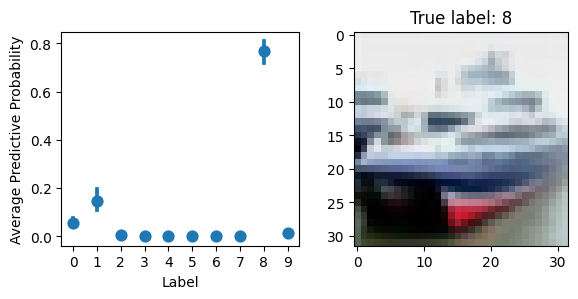

In [11]:
sample = 1
fig, axs = plt.subplots(1,2,figsize=(6,3))
total_unc, ale_unc, epi_unc = compute_uncertainties(predictions)
df = pd.DataFrame(predictions[:,sample,:], columns=[f"{i}" for i in range(10)])
df_melted = df.melt(var_name="Label", value_name="Predictive Probability")
    
sns.pointplot(x="Label", y="Predictive Probability", data=df_melted, errorbar="ci", linestyle="none", ax=axs[0])
axs[0].set_ylabel("Average Predictive Probability")
axs[0].set_xlabel("Label")

img_ax = axs[1]
img_ax.imshow(Xtest[sample].squeeze())
        
img_ax.set_title(f"True label: {ytest[sample]}")

plt.tight_layout()
plt.show()

## Thresholded Accuracy

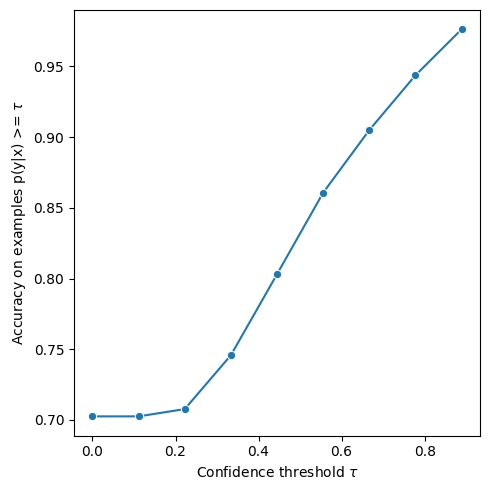

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
mc_predictions_max_val = np.max(predictions, axis=2) # (num_passes, num_samples)
mc_predictions_max_class = np.argmax(predictions, axis=2) # (num_passes, num_samples)

threshold_values = np.linspace(0,1,10)
num_passes, num_samples = mc_predictions_max_val.shape
accuracies = np.zeros((len(threshold_values), num_passes))
num_labels = np.zeros((len(threshold_values), num_passes))
    
for i, threshold in enumerate(threshold_values):
    for pass_idx in range(num_passes):
        mask = mc_predictions_max_val[pass_idx] > threshold
                
        valid_preds = mc_predictions_max_class[pass_idx][mask]
        valid_labels = ytest[mask]
                
        if len(valid_labels) > 0: 
            accuracies[i, pass_idx] = np.mean(valid_preds == valid_labels)
        else:
            accuracies[i, pass_idx] = np.nan
        num_labels[i, pass_idx] = len(valid_labels)
        
accuracies_avg_passes = accuracies.mean(1)
num_labels_avg_passes = num_labels.mean(1)
sns.lineplot(x=threshold_values, y=accuracies_avg_passes, marker='o', ax=ax)
    
ax.set_xlabel(r'Confidence threshold $\tau$')
ax.set_ylabel(r'Accuracy on examples p(y|x) >= $\tau$')
plt.tight_layout()
plt.show()

## Posterior over some convolutional parameters

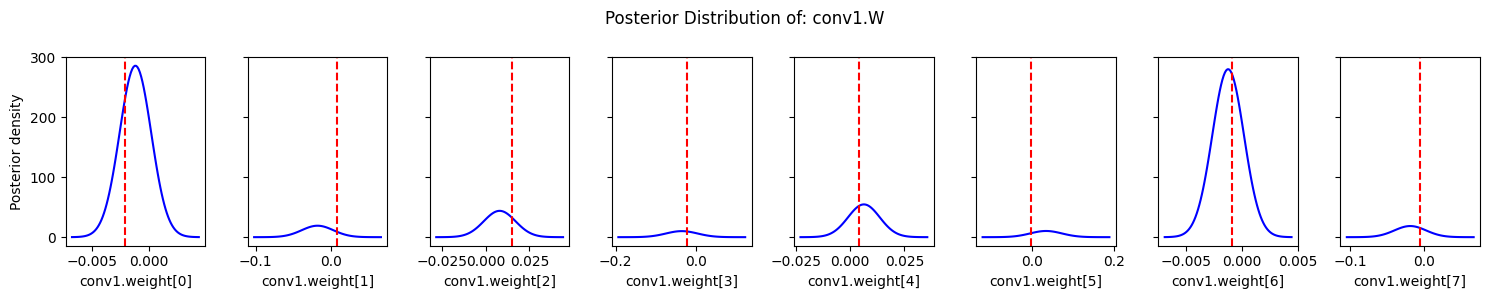

In [13]:
param_name = 'conv1.W'
mean = net.theta_mean[param_name].cpu().detach().numpy()
variance = net.theta2_mean[param_name].cpu().detach().numpy()

fig, axs = plt.subplots(1,8,sharey=True,figsize=(15,3))
for val in range(8):
    # Select one value
    mean_value = mean.flatten()[val]
    variance_value = variance.flatten()[val]
    stddev_value = np.sqrt(variance_value)

    x_values = np.linspace(mean_value - 4*stddev_value, mean_value + 4*stddev_value, 100)
    pdf_values = norm.pdf(x_values, loc=mean_value, scale=stddev_value)
    point_est = net.base_model.state_dict()[param_name].cpu().detach().numpy().flatten()[val]

    # Plot the posterior distribution
    sns.lineplot(x=x_values, y=pdf_values, color='blue', ax=axs[val])
    axs[val].axvline(x=point_est, color='red', linestyle='--')
    axs[val].set_xlabel(f'conv1.weight[{val}]')
    axs[val].set_ylabel('Posterior density')

fig.suptitle(f'Posterior Distribution of: {param_name}')
plt.tight_layout()
plt.show()